# Line segment to obstacle

In [2]:
import shapely
import numpy as np
from shapely import affinity
from shapely.plotting import plot_line,plot_polygon

In [3]:
bloating_r = 0.5 
x1,x2 = np.array([0,0]), np.array([0,1])


b = shapely.geometry.LineString([x1,x2])
b_p = affinity.scale(affinity.rotate(b,90),
             xfact = 2*bloating_r/b.length,
             yfact = 2*bloating_r/b.length,
          )

d = (x2-x1)*(1/2+bloating_r/b.length)

side_1 = affinity.translate(b_p,*d)
side_2 = affinity.translate(b_p,*(-d))

(<matplotlib.patches.PathPatch at 0x1189c2ad0>,
 <matplotlib.lines.Line2D at 0x118b01f50>)

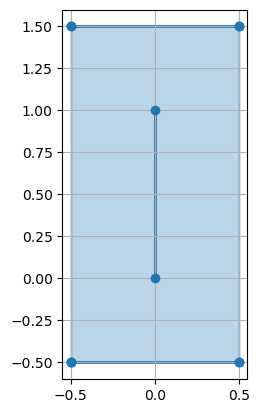

In [4]:


plot_line(b)
# plot_line(b_p)

plot_line(side_1)

plot_line(side_2)

poly = shapely.geometry.Polygon([*side_1.coords,*side_2.coords]).convex_hull

plot_polygon(poly)

In [6]:
[*side_1.coords,*side_2.coords]

[(0.5, 1.5), (-0.5, 1.5), (0.5, -0.5), (-0.5, -0.5)]

In [ ]:
import cvxpy as cp

In [162]:
agent = 0

bloating_r = 0.5

d = 2
K = 10
t0 = 0
vmax = 1.0
M = 100 * np.max(np.abs(env.limits))


start = env.starts[agent]
goal = env.goals[agent]

x = cp.Variable((d, K+1))
t = cp.Variable(K+1)

constraints = []

# Boundary constraints
constraints.append(x <= np.array(env.limits)[:,-1].reshape(-1,1) - bloating_r)
constraints.append(x >= np.array(env.limits)[:,0].reshape(-1,1) + bloating_r)

# Start and goal constraints
constraints.append(start.A @ x[:,0] <= start.b)
constraints.append(goal.A @ x[:,-1] <= goal.b)

# Velocity constraints
vb = vmax*(t[1:]-t[:-1])
for i in range(d):
    diff = x[i,1:]-x[i,:-1]
    constraints.append(np.sqrt(2) * diff <= vb)
    constraints.append(- vb <= np.sqrt(2) * diff)
    

# Static obstacle constraints
for O in env.obstacles:
    A, b= O.A,O.b
    
    H = A @ x-(b+ np.linalg.norm(A) * bloating_r).reshape(-1,1) # Bloating radius

    alpha = cp.Variable((H.shape[0],K),boolean=True)
    
    constraints.append(H[:,1:] + M * (1-alpha)>=0)
    constraints.append(H[:,:-1] + M * (1-alpha)>=0)
    
    constraints.append(cp.sum(alpha,axis = 0)>=1)


# Time positivity constraint
constraints.append(t[0]==t0)
constraints.append(t[1:]>=t[:-1])

prob = cp.Problem(cp.Minimize(t[-1]),constraints)

prob.solve()

22.059010925024964

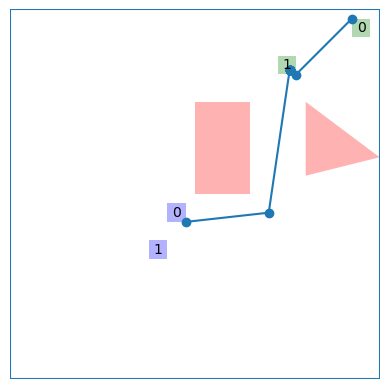

In [163]:
ax = plt.gca()
draw_env(env, ax)
ax.plot(x.value[0,:],x.value[1,:],marker = 'o')